In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME= './config_bdd.csv' #'./config_bdd50K.csv' # "/mnt/temp_dd/igrida-fs1/macher/config_bdd30To102K.csv" # "config_bdd83K.csv" # 'config_bdd1K.csv' # # "./config_bdd.csv" # 

# sanity check CSV
with open(TUXML_CSV_FILENAME, "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    assert(len(t) == len(s)) # unique number of options/features/column names

# parsing for real with pandas 
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "date"] # "compile"
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


### basic stats about options and remove of unique values 
## could be improved 

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
# TODO: maybe we can rely on more traditional feature reduction techniques
# TODO: need to think about *when* to apply the removal 
rawtuxdata.drop(columns=ftuniques,inplace=True) 
## non_tristate_options include basic stuff like date, time, cid but also string/numerical options
print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))


print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1150,2722,6717,7350,7676,7726) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (977, 12798)
Number of options with only one value (eg always y): (3428, 1)
Non tri-state value options (eg string or integer or hybrid values): (146, 1) 
Predictor variables: 9224


In [2]:
# debugging some old entries
for k, v in rawtuxdata['LZO'].iteritems():
    if isinstance(v, str):
        print (rawtuxdata.loc[k]['cid'], v)

In [3]:
'X86_64' in ftuniques, 'DEBUG_INFO' in ftuniques, 'GCOV_PROFILE_ALL' in ftuniques, 'KASAN' in ftuniques, 'UBSAN_SANITIZE_ALL' in ftuniques, 'RELOCATABLE' in ftuniques, 'XFS_DEBUG' in ftuniques, 'AIC7XXX_BUILD_FIRMWARE' in ftuniques, 'AIC79XX_BUILD_FIRMWARE' in ftuniques, 'WANXL_BUILD_FIRMWARE' in ftuniques

(True, False, False, False, False, False, False, True, True, True)

In [4]:
# tinyconfig 
rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts()

KeyError: 'SLOB'

In [5]:
if 'RELOCATABLE' in rawtuxdata.columns:
    print(rawtuxdata.query("RELOCATABLE == 'y'")[['cid', 'RELOCATABLE']], rawtuxdata.query("RELOCATABLE == 'y'").shape)

       cid RELOCATABLE
1    24001           y
2    24002           y
3    24003           y
4    24004           y
5    24005           y
6    24006           y
9    24009           y
10   24010           y
11   24011           y
14   24014           y
15   24015           y
16   24016           y
17   24017           y
18   24018           y
19   24019           y
21   24021           y
25   24025           y
29   24029           y
31   24031           y
32   24032           y
33   24033           y
34   24034           y
35   24035           y
44   24044           y
47   24047           y
48   24048           y
51   24051           y
53   24053           y
56   24056           y
58   24058           y
..     ...         ...
926  24949           y
927  24950           y
928  24951           y
929  24952           y
930  24953           y
932  24955           y
934  24957           y
935  24958           y
937  24960           y
938  24961           y
939  24962           y
941  24964 

In [6]:
print("Data exploration")

Data exploration


In [7]:
# BUGS EXPLORATION
def bug_exploration():
    rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("AIC79XX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("WANXL_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'y' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'm'")[['cid', 'vmlinux']]
    return rawtuxdata.query("DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]

#bug_exploration()





In [8]:
#rawtuxdata[rawtuxdata['X86_64'] == 'n']
#rawtuxdata.query("X86_64 == 'n'")

In [9]:
#rawtuxdata[(rawtuxdata['DEBUG_INFO'] == 'n') & (rawtuxdata['GCOV_PROFILE_ALL'] == 'n') & (rawtuxdata['KASAN'] == 'n') & (rawtuxdata['MODULES'] == 'y')]
# rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n') & (MODULES == 'y')")
#rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n')").shape, rawtuxdata.shape


In [10]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]
tiny_data = rawtuxdata.query("vmlinux == 1168072") #tiny config for X86_32
#if (len(tiny_data) > 0):
#    print(tiny_data[['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']])

In [11]:
#rawtuxdata[rawtuxdata['vmlinux'] == -1]
rawtuxdata.query("vmlinux == -1")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [12]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]['MODULES']
rawtuxdata.query("vmlinux == 1168072")['MODULES'] #tiny config for X86_32

Series([], Name: MODULES, dtype: object)

In [13]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0      41526016
1      87642608
2      18519616
3     158911984
4      56091920
5      30678024
6     123549888
7      41634848
8      36068416
9      65717608
10     48770152
11     54531376
12     24347504
13     79780576
14     38718224
15    216009344
16    163108344
17     76584824
18    170449104
19     28264736
Name: vmlinux, dtype: int64

In [14]:
rawtuxdata.shape, rawtuxdata.query("vmlinux != -1").shape

((977, 9370), (977, 9370))

In [15]:
print("some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)")
# we only keep X86_64 configurations
#rawtuxdata = rawtuxdata[rawtuxdata['X86_64'] == 'y'] ### TODO: I've impression it's not the most effective way (wrt memory) to filter 
if 'X86_64' in rawtuxdata.columns:
    print(rawtuxdata['X86_64'].describe())
    rawtuxdata.query("X86_64 == 'y'", inplace=True)
rawtuxdata.info(memory_usage='deep')

some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Columns: 9370 entries, cid to NETWORK_FILESYSTEMS
dtypes: float64(1), int64(134), object(9235)
memory usage: 568.4 MB


In [16]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree
import graphviz 


LEARN_COMPILATION_SUCCESS = False # costly in time and space 
compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    # we can ue vmlinux since it has been restored thanks to previous line
    tuxdata_for_compilation[compilation_status_column_name] = tuxdata_for_compilation['vmlinux'] != -1
    return tuxdata_for_compilation

def learn_compilation_success(tuxdata_for_compilation):
    TESTING_SIZE=0.3 
    X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
    clf = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))
   
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name).columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("TUXML compilation sucess")
    
    acc = accuracy_score (y_test, y_pred)
    prec = precision_score (y_test, y_pred)
    reca = recall_score (y_test, y_pred)
    f1 = f1_score (y_test, y_pred)
    print("Accuracy score: %.2f" % (acc))
    print("Precision score: %.2f" % (prec))
    print("Recall score: %.2f" % (reca))
    print("F1 score: %.2f" % (f1))

if (LEARN_COMPILATION_SUCCESS):
    tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
    tuxdata_for_compilation [compilation_status_column_name].describe()
    learn_compilation_success(tuxdata_for_compilation)
    del tuxdata_for_compilation

In [17]:
#rawtuxdata.query("vmlinux == -1")[['cid', 'AIC7XXX_BUILD_FIRMWARE', 'AIC79XX_BUILD_FIRMWARE', 'IPVTAP', 'WANXL_BUILD_FIRMWARE', 'TCIC']]


In [18]:
# aka MAPE
def mean_relative_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [19]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
#n_failures = len(rawtuxdata.query("vmlinux != -1")) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
#print(str(n_failures) + " non-failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
#rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata.query("(vmlinux != -1) & (vmlinux != 0)", inplace=True)
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")


977 before the removal of some entries (those with same configurations)
977 after the removal of some entries (those with same configurations)
977 after the removal of configurations that do NOT compile


In [20]:
rawtuxdata.query("vmlinux == 1168072") # tinyconfig with X86_32

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [21]:
rawtuxdata.query("vmlinux == 7317008") # tiny config for X86_64

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,VIDEO_S3C_CAMIF,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


<Figure size 432x288 with 0 Axes>

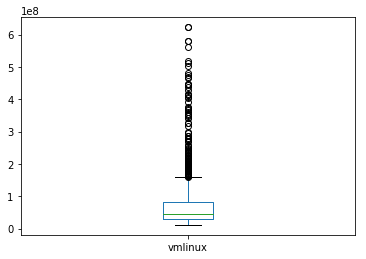

<Figure size 432x288 with 0 Axes>

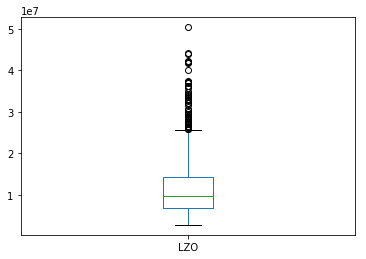

<Figure size 432x288 with 0 Axes>

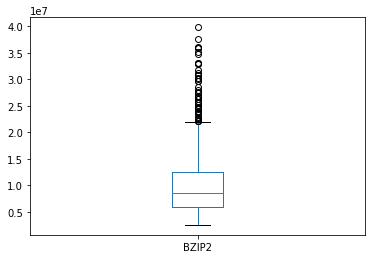

count    9.770000e+02
mean     7.660170e+07
std      8.869261e+07
min      1.110275e+07
25%      2.908516e+07
50%      4.510860e+07
75%      8.106434e+07
max      6.224821e+08
Name: vmlinux, dtype: float64

In [22]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show(block=False)


rawtuxdata['vmlinux'].describe()


In [23]:
rawtuxdata['vmlinux'].sort_values()[:100]

450    11102752
103    12231648
296    13594296
741    13753648
348    13968144
331    14997224
635    15456360
912    16044736
59     16060000
872    16113376
955    16352952
729    16425664
37     16537560
923    16540944
466    16765424
362    16943064
132    17047720
631    17224480
295    17244464
606    17292136
500    17296592
641    17385624
468    17461336
540    17515400
915    17595856
949    17667304
60     17831528
827    17890928
229    17901504
950    17976968
         ...   
745    20742880
421    20796952
930    20811584
245    20811880
467    20853416
627    20882384
691    20890544
604    20942016
403    20953536
442    20962896
687    21000264
266    21007208
520    21056000
377    21092320
764    21167920
755    21178040
101    21183248
330    21219952
762    21229064
26     21243816
473    21276560
408    21352576
477    21358512
143    21390728
303    21404744
826    21434992
542    21456488
418    21485544
628    21498008
505    21525504
Name: vmlinux, Length: 1

In [24]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,3.13445,25.2659,39.2348,-10.2768,-16.3912
BZIP2o,-2.94677,0,21.5728,35.084,-12.9672,-18.9197
LZMAo,-20.0905,-17.59,0,11.1593,-28.2647,-33.1363
XZo,-27.854,-25.6217,-9.71196,0,-35.2428,-39.641
LZOo,11.5396,14.9731,39.8071,55.3737,0,-6.84596
LZ4o,19.8038,23.4557,50.2137,66.9365,7.36924,0


In [25]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-30.4369,24.8591,38.2235,-9.96328,-16.1134
BZIP2o,48.015,0,84.1758,103.532,33.3631,24.3002
LZMAo,-19.8286,-44.4179,0,10.7065,-27.7775,-32.6946
XZo,-27.3299,-49.691,-9.35702,0,-34.5425,-38.9993
LZOo,11.1497,-22.6239,38.8668,53.7105,0,-6.86099
LZ4o,19.4018,-16.8449,49.2226,65.171,7.38563,0


In [26]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-25.6747,19.3096,28.9367,-8.19563,-13.4088
BZIP2o,36.4425,0,62.1416,74.9374,25.4205,18.3908
LZMAo,-16.0509,-37.8502,0,8.03577,-22.8735,-27.2244
XZo,-22.105,-42.4222,-7.24235,0,-28.4306,-32.4626
LZOo,9.006,-18.8773,30.1632,40.6743,0,-5.71085
LZ4o,15.6748,-13.8463,38.1907,49.3608,6.07783,0


In [27]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.534178,0.534192,0.533549,0.544095,0.544411,0.543569,0.524241,0.52426,0.523368,0.533111,0.53313,0.532185,0.544397,0.544407,0.543947,0.547208,0.547216,0.546824
GZIP-bzImage,0.534178,1,1,0.99999,0.996917,0.996386,0.997111,0.997887,0.997888,0.997814,0.993376,0.993377,0.993312,0.997175,0.99717,0.997317,0.994113,0.994108,0.994303
GZIP-vmlinux,0.534192,1,1,0.999989,0.996922,0.996391,0.997116,0.997885,0.997887,0.997812,0.993376,0.993376,0.99331,0.99718,0.997175,0.997321,0.99412,0.994115,0.99431
GZIP,0.533549,0.99999,0.999989,1,0.996707,0.996171,0.996922,0.997916,0.997917,0.99787,0.993392,0.993392,0.993357,0.996991,0.996986,0.99715,0.993852,0.993846,0.994058
BZIP2-bzImage,0.544095,0.996917,0.996922,0.996707,1,0.999483,0.999989,0.994303,0.994312,0.993962,0.991012,0.991021,0.99066,0.998141,0.998141,0.99811,0.997196,0.997194,0.997229
BZIP2-vmlinux,0.544411,0.996386,0.996391,0.996171,0.999483,1,0.999467,0.993803,0.993812,0.993455,0.990468,0.990477,0.99011,0.997649,0.99765,0.997614,0.996709,0.996708,0.996739
BZIP2,0.543569,0.997111,0.997116,0.996922,0.999989,0.999467,1,0.994537,0.994545,0.994224,0.991232,0.99124,0.99091,0.998156,0.998156,0.998144,0.997132,0.99713,0.997181
LZMA-bzImage,0.524241,0.997887,0.997885,0.997916,0.994303,0.993803,0.994537,1,1,0.999982,0.994135,0.994134,0.994128,0.991758,0.991753,0.991933,0.987301,0.987294,0.98752
LZMA-vmlinux,0.52426,0.997888,0.997887,0.997917,0.994312,0.993812,0.994545,1,1,0.999981,0.994136,0.994135,0.994128,0.991767,0.991761,0.991941,0.987312,0.987305,0.98753
LZMA,0.523368,0.997814,0.997812,0.99787,0.993962,0.993455,0.994224,0.999982,0.999981,1,0.9941,0.994097,0.994132,0.991451,0.991445,0.991649,0.986889,0.986882,0.98713


In [28]:
#from category_encoders import *
from sklearn.preprocessing import *

## class to integer encoding (y, n, m)

## note: we also remove non-tristate-options
# "in place" is to avoid memory burden (having two dfs in memory)

# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
rawtuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
rawtuxdata[size_methods] = vml
 
rawtuxdata.shape, rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977 entries, 0 to 976
Columns: 9224 entries, OPENVSWITCH to LZ4
dtypes: int64(9224)
memory usage: 68.8 MB


((977, 9224), None)

In [29]:
#### takes a while
# One-Hot-Encoding 
#from sklearn.preprocessing import *

#enc = OneHotEncoder()
#o_sizes = rawtuxdata[size_methods]
#oh_tuxdata = enc.fit_transform(rawtuxdata)
#oh_tuxdata.shape, o_sizes.shape
# rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(enc.fit_transform)
#oh_tuxdata[size_methods] = o_sizes

In [30]:
# DUMMY (with Pandas)

#o_sizes = tuxdata[size_methods]
#tuxdata_dummy = pd.get_dummies(rawtuxdata.drop(columns=size_methods), columns=rawtuxdata.drop(columns=size_methods).columns)
#tuxdata_dummy[size_methods] = o_sizes
#tuxdata_dummy.shape

In [31]:
# Data exploration (again)
#print(rawtuxdata['UBSAN_SANITIZE_ALL'].value_counts(), rawtuxdata['COMPILE_TEST'].value_counts(), rawtuxdata['NOHIGHMEM'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts(), rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), sep='\n')

In [32]:
from enum import Enum
class LearningStrategy(Enum):
    LINEAR = 1
    AUTOML = 2
    ML = 3
    DT = 4 # decision tree

In [33]:
from sklearn.pipeline import Pipeline

# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [34]:
NO_ENCODED_VALUE = le.transform(['n'])[0] 
YES_ENCODED_VALUE = le.transform(['y'])[0] 
M_ENCODED_VALUE = le.classes_.size # last value, we know that

def mkNoOption(option_name):
    return "(" + option_name + " == " + str(NO_ENCODED_VALUE) + ")"

def mkNoOptions(l_options):
    r = []
    for option_name in l_options:
        r.append(mkNoOption(option_name))
        
    return ' & '.join(r)

mkNoOptions(['DEBUG_INFO', 'GCOV_PROFILE_ALL', 'KASAN', 'UBSAN_SANITIZE_ALL', 'RELOCATABLE', 'XFS_DEBUG'])
  

'(DEBUG_INFO == 0) & (GCOV_PROFILE_ALL == 0) & (KASAN == 0) & (UBSAN_SANITIZE_ALL == 0) & (RELOCATABLE == 0) & (XFS_DEBUG == 0)'

In [35]:

def nbyes(row):
    return sum(row == YES_ENCODED_VALUE)

def nbno(row):
    return sum(row == NO_ENCODED_VALUE)

def nbmodule(row):
    return sum(row == M_ENCODED_VALUE)
                    
rawtuxdata['nbyes'] = rawtuxdata.apply(nbyes, axis=1)
rawtuxdata['nbno'] = rawtuxdata.apply(nbno, axis=1)
rawtuxdata['nbmodule'] = rawtuxdata.apply(nbmodule, axis=1)
rawtuxdata['nbyesmodule'] = rawtuxdata['nbyes'] + rawtuxdata['nbmodule']
rawtuxdata.sort_values(by='nbyes',ascending=False)[['vmlinux', 'nbyes', 'nbyesmodule']]

,vmlinux,nbyes,nbyesmodule
591,42837504,6211,6457
20,27737416,6089,6766
258,31924184,6068,6309
522,43301808,6060,6837
807,28563816,6058,6711
753,82336976,6041,6747
329,26698520,6028,6379
344,166252296,6024,6762
786,23926936,6015,6191
670,236483968,6014,6947


In [36]:
import scipy.stats
scipy.stats.pearsonr(rawtuxdata['nbyes'], rawtuxdata['vmlinux']), scipy.stats.pearsonr(rawtuxdata['nbyesmodule'], rawtuxdata['vmlinux']), scipy.stats.pearsonr(rawtuxdata['nbno'], rawtuxdata['vmlinux'])

#scipy.stats.pearsonr(
size_and_nbs = rawtuxdata.query(mkNoOptions(['DEBUG_INFO', 'GCOV_PROFILE_ALL', 'KASAN', 'UBSAN_SANITIZE_ALL', 'RELOCATABLE', 'XFS_DEBUG']))[['vmlinux', 'nbyes', 'nbno', 'nbyesmodule']]
scipy.stats.pearsonr(size_and_nbs['vmlinux'], size_and_nbs['nbyes'])
        
            


(-0.4197256255355528, 9.959137519822962e-09)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPRegressor

# domain knowledge: intuitively the more you have activated options...
# there is no correlation between these (hidden) predictors and size
nbdk_features = ['nbyes', 'nbno', 'nbmodule', 'nbyesmodule'] 
def prefilter_data(tuxdata):    
    #return rawtuxdata.drop(columns=nbdk_features)
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO"))
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO") + " & " + mkNoOption("GCOV_PROFILE_ALL") + " & " + mkNoOption("KASAN") + " & " + mkNoOption("UBSAN_SANITIZE_ALL") + " & " + mkNoOption("RELOCATABLE") + " & " + mkNoOption("XFS_DEBUG"))
    return rawtuxdata.query(mkNoOptions(['DEBUG_INFO', 'GCOV_PROFILE_ALL', 'KASAN', 'UBSAN_SANITIZE_ALL', 'RELOCATABLE', 'XFS_DEBUG']))#.drop(columns=nbdk_features)  
                

def regLearning(tuxdata, kindOfLearning=LearningStrategy.ML):
 
    TESTING_SIZE=0.3 # 0.9 means 10% for training, 90% for testing
    size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 
    PRINT_FEATURE_IMPORTANCES = False
   
       
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])].drop(columns=size_methods), tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])][size_of_interest], test_size=TESTING_SIZE, random_state=0)  
    print ("Warning: prefiltering on DEBUG_INFO=n GCOV_PROFILE_ALL=n KASAN=n ....")   
    X_train, X_test, y_train, y_test = train_test_split(prefilter_data(tuxdata).drop(columns=size_methods), prefilter_data(tuxdata)[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
  
    # multi output
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

    # train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

    #clf = RandomForestRegressor(n_estimators=100) 

    if kindOfLearning == LearningStrategy.LINEAR:
        regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

    elif kindOfLearning == LearningStrategy.AUTOML:


        tpot_config = {

            'sklearn.linear_model.ElasticNetCV': {
                'l1_ratio': np.arange(0.0, 1.01, 0.05),
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
            },

            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.ensemble.GradientBoostingRegressor': {
                'n_estimators': [100],
                'loss': ["ls", "lad", "huber", "quantile"],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'subsample': np.arange(0.05, 1.01, 0.05),
                'max_features': np.arange(0.05, 1.01, 0.05),
                'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
            },

            'sklearn.ensemble.AdaBoostRegressor': {
                'n_estimators': [100],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'loss': ["linear", "square", "exponential"],
                'max_depth': range(1, 11)
            },

            'sklearn.tree.DecisionTreeRegressor': {
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21)
            },

            'sklearn.neighbors.KNeighborsRegressor': {
                'n_neighbors': range(1, 101),
                'weights': ["uniform", "distance"],
                'p': [1, 2]
            },

            'sklearn.linear_model.LassoLarsCV': {
                'normalize': [True, False]
            },

            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            },

            'sklearn.ensemble.RandomForestRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.linear_model.RidgeCV': {
            },

            'xgboost.XGBRegressor': {
                'n_estimators': [100],
                'max_depth': range(1, 11),
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'subsample': np.arange(0.05, 1.01, 0.05),
                'min_child_weight': range(1, 21),
                'nthread': [1]
            }     
        }

        #tpot = TPOTRegressor(generations=5, population_size=50, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot = TPOTRegressor(generations=2, population_size=5, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot.fit(X_train, y_train)
        y_pred = tpot.predict(X_test)
        print(tpot.score(X_test, y_test))
        print(tpot.evaluated_individuals_)
        tpot.export('tpot_boston_pipeline.py')
        
    elif kindOfLearning == LearningStrategy.DT:
        clf = tree.DecisionTreeRegressor() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=tuxdata.drop(columns=size_methods).columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
        graph = graphviz.Source(dot_data)  
        graph.render("TUXML-DT-" + size_of_interest)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))


    else:
        assert (kindOfLearning == LearningStrategy.ML)
        clf = GradientBoostingRegressor(n_estimators=100) # RandomForestRegressor(n_estimators=100) # #GradientBoostingRegressor(n_estimators=100) # KNeighborsRegressor() #RandomForestRegressor(n_estimators=100) # linear_model.SGDRegressor(alpha=0.15, max_iter=200)
        # #LassoLarsCV() # MLPRegressor() # GradientBoostingRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #  #   GradientBoostingRegressor(n_estimators=100) # 
        # 
        #estimator = RandomForestRegressor(n_estimators=100) # RidgeCV(alphas=[1000.0]) # LassoCV(tol = 0.001) #   #  # RandomForestRegressor(n_estimators=100) #LassoCV() #RidgeCV(alphas=[2000.0]) # LassoCV()
        #clf = PipelineRFE([ # Pipeline([
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = PipelineRFE([
          #('reduce_dim', PCA()),
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        #    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100)),
        #    KNeighborsRegressor(n_neighbors=82, p=2, weights="distance")
        #)
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        #    RidgeCV()
        #)


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure()
    #plt.title("Feature importances for size of vmlinux")
    #plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
    #plt.xticks(range(tuxdata.shape[1]), indices)
    #plt.xlim([-1, tuxdata.shape[1]])
    #plt.show()
    mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
    mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
    r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 
    mre = mean_relative_error (y_test, y_pred)

    ONE_MEGABYTE = 1048576

    print("Prediction score (MAE): %.2f" % (mae / ONE_MEGABYTE))
    print("Prediction score (MSE): %.2f" % (mse / ONE_MEGABYTE))
    print("Prediction score (R2): %.2f" % (r2))
    print("Prediction score (MRE): %.2f" % (mre))
    return y_pred, y_test
    
pr, re = regLearning(rawtuxdata, LearningStrategy.ML)
#regLearning(tuxdata_dummy)


Prediction score (MAE): 3.39
Prediction score (MSE): 24126883.12
Prediction score (R2): 0.74
Prediction score (MRE): 12.46


In [39]:
#re[56589]



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True)
tuxdata_reduced = model.transform(prefilter_data(rawtuxdata).drop(columns=size_methods))
tuxdata_reduced.shape, tuxdata.shape


In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE


#alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]
#selector = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]) # LassoCV(tol = 0.001) # RidgeCV(alphas=[2000.0])  # 
#lass = selector #SelectFromModel(selector) #  RFECV(estimator=selector, step=1, scoring='neg_mean_squared_error') # 
#lass = RFE(estimator=selector, step=1)
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape  
#lass.alpha_ 



In [ ]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=100)
#pca.fit(X_train, y_train)

#tuxdata_reduced_pca = pca.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_pca.shape, tuxdata.shape  

#pca.components_.shape

#plt.matshow(pca.components_, cmap='viridis')
#plt.yticks([0, 1], ["First component", "Second component"])
#plt.colorbar()
#plt.xticks(range(len(X_train.columns)),
#           X_train.columns, rotation=60, ha='left')
#plt.xlabel("Feature")
#plt.ylabel("Principal components")

In [ ]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

In [ ]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [ ]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [ ]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [ ]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [ ]:
#size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
#              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
#              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
#size_methods_without_soi

In [ ]:
#import h2o
#from h2o.automl import H2OAutoML
#h2o.init()
#df = h2o.import_file(TUXML_CSV_FILENAME)

In [ ]:
#df.describe()

In [ ]:
#splits = df.split_frame(ratios = [0.8], seed = 1)
#train = splits[0]
#test = splits[1]

In [ ]:
#y = size_of_interest
#aml = H2OAutoML(max_runtime_secs = 36000, seed = 1, project_name = "tuxlearning")
#aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [ ]:
#aml.leaderboard.head()

In [ ]:
#pred = aml.predict(test)
#pred.head()

In [ ]:
#perf = aml.leader.model_performance(test)
#perf

In [ ]:
#h2o.shutdown()

In [ ]:
#import category_encoders as ce

#colmatters = list(tuxdata.columns)
#for s in size_methods:
#    colmatters.remove(s)
    
# colmatters.remove(size_methods)
#encoder = ce.OneHotEncoder(cols=colmatters) #cols=tuxdata.drop(columns=size_methods).columns

#o_sizes = tuxdata[size_methods]
#encoder.fit(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2 = encoder.transform(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2[size_methods] = o_sizes

In [ ]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]#['MODULES']

In [ ]:
#tuxdata_dummy2.shape, tuxdata.shape

In [ ]:
#rawtuxdata[(rawtuxdata['MODULES'] == 'y')]['vmlinux'].describe(), rawtuxdata[(rawtuxdata['MODULES'] == 'n')]['vmlinux'].describe()
#rawtuxdata[(rawtuxdata['UBSAN_SANITIZE_ALL'] == 'y')]
# [['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

In [ ]:
rawtuxdata.info(memory_usage='deep')